In [7]:
# preliminary code

# enable hot reload of imported code
%load_ext autoreload
%autoreload 2

In [1]:
# enable src imports if needed (setting an env variable may be enough too)
import sys
sys.path.append("..")

In [2]:
import torch
import numpy as np
import pandas as pd
import wandb
import json
import os
import re
from collections import defaultdict 

from matplotlib.collections import LineCollection

from src.utils.model_utils import *

import matplotlib.pyplot as plt

import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

import seaborn as sns
from sklearn.metrics import ndcg_score, average_precision_score

available metrics
```
t2s_R@1
t2s_R@5
t2s_R@10
t2s_median_rank
t2s_mean_rank
t2s_class_R@1
t2s_class_R@5
t2s_class_R@10
t2s_class_P@1
t2s_class_P@5
t2s_class_P@10
s2t_R@1
s2t_R@5
s2t_R@10
s2t_median_rank
s2t_mean_rank
s2t_class_R@1
s2t_class_R@5
s2t_class_R@10
s2t_class_P@1
s2t_class_P@5
s2t_class_P@10
t2s_avg_ndcg
s2t_avg_ndcg
s2t_avg_ndcg_by_class
t2s_avg_ndcg_by_class
s2t_mAP
t2s_mAP
s2t_mAP_by_class
t2s_mAP_by_class
```

In [3]:
wandb_project = "paperDigitalArtExhibitions"
wandb_entity = "gianluca18"
WANDB_API = wandb.Api()

In [4]:
def create_local_res_dir(base_name, dataset_name, n_tries, base_path=None):
    dir_name = f'{dataset_name}_{base_name}_{n_tries-1}'
    if base_path:
        dir_name = os.path.join(base_path, dir_name)
    return dir_name

def create_local_res_dir_from_run(run, n_tries, dataset_name, base_path=None):
    return create_local_res_dir(run.config['run'], dataset_name, n_tries, base_path)

def create_local_res_dir_from_runs(runs, dataset_name, base_path=None):
    return create_local_res_dir_from_run(runs[0], len(runs), dataset_name, base_path)

In [5]:
def get_summary_metrics(wandb_entity, wandb_project, wandb_runs_filter, summary_key_filter_f, wandb_api=WANDB_API):
   """get mean and std values for some metrics filtered with summary_key_filter_f from runs filtered by run_filter and grouped by the the run name

   Args:
       summary_key_filter_f : function to filter the summary key strings

   """
   runs = wandb_api.runs(f"{wandb_entity}/{wandb_project}", filters=wandb_runs_filter) 

   tries_by_run = defaultdict(lambda:[])
   for run in runs:
      tries_by_run[run.config['run']].append(run)

   all_runs_data = {}

   for run_name, tries in tries_by_run.items():
      run_df = pd.DataFrame([{k:v for k,v in el.summary.items() if summary_key_filter_f(k)} for el in tries])
      all_runs_data[run_name] ={name:f'{row["mean"]:.1f}'+ (f'({row["std"]:.1f})').rjust(7) for name, row in pd.DataFrame([run_df.mean(axis=0), run_df.std(axis=0)], index=['mean', 'std']).T.iterrows()}

   return pd.DataFrame(all_runs_data).T


def get_summary_means(wandb_entity, wandb_project, wandb_runs_filter, summary_key_filter_f, wandb_api=WANDB_API):
   """get mean and std values for some metrics filtered with summary_key_filter_f from runs filtered by run_filter and grouped by the the run name

   Args:
       summary_key_filter_f : function to filter the summary key strings

   """
   runs = wandb_api.runs(f"{wandb_entity}/{wandb_project}", filters=wandb_runs_filter) 

   tries_by_run = defaultdict(lambda:[])
   for run in runs:
      tries_by_run[run.config['run']].append(run)

   all_runs_data = {}

   for run_name, tries in tries_by_run.items():
      run_df = pd.DataFrame([{k:v for k,v in el.summary.items() if summary_key_filter_f(k)} for el in tries])
      all_runs_data[run_name] = run_df.mean(axis=0)
   return pd.DataFrame(all_runs_data).T


In [6]:
def get_run_config(run_name, wandb_api=WANDB_API):
    runs = wandb_api.runs(f"{wandb_entity}/{wandb_project}", filters={'config.run_uid':run_name.split('_')[0]}) 
    return runs[0].config

## hierart comparison

In [80]:
summary_key_filter_f = lambda k: re.match(r'test/((s2t)|(t2s))_(R|(median))',k)

runs_filter = {"tags":{'$eq':'hierart_comparison'}}
data_df = get_summary_metrics(wandb_entity, wandb_project, runs_filter, summary_key_filter_f)

# columns sorting
data_df = data_df[[
        "test/t2s_R@1",
        "test/t2s_R@5",
        "test/t2s_R@10",
        "test/t2s_median_rank",
        "test/s2t_R@1",
        "test/s2t_R@5",
        "test/s2t_R@10",
        "test/s2t_median_rank"]]

data_df.columns = [c.replace('median_rank', 'medR') for c in data_df.columns]
data_df.columns = pd.MultiIndex.from_tuples([(c[5:8],c[9:]) for c in data_df.columns])

print(data_df.to_latex())


\begin{tabular}{lllllllll}
\toprule
 & \multicolumn{4}{r}{t2s} & \multicolumn{4}{r}{s2t} \\
 & R@1 & R@5 & R@10 & medR & R@1 & R@5 & R@10 & medR \\
\midrule
1tjN5i_hier_by_room_rnn_meanPoolProc_cnn1d & 6.1  (2.1) & 25.8  (6.4) & 42.4  (7.2) & 14.0  (3.6) & 6.3  (0.7) & 26.6  (5.5) & 42.8  (5.4) & 14.7  (4.0) \\
1tjMpm_hier_by_room_rnn_2_meanPoolProc & 36.8 (11.0) & 67.5 (10.7) & 80.1  (8.1) & 3.0  (1.0) & 35.0 (10.1) & 65.3 (11.2) & 78.7  (8.1) & 3.0  (1.0) \\
1tjMa8_hier_by_room_rnn_meanPoolProc & 84.2  (2.0) & 97.3  (0.6) & 99.0  (0.3) & 1.0  (0.0) & 82.9  (1.1) & 97.0  (0.5) & 98.9  (0.7) & 1.0  (0.0) \\
1tjMP3_rnn_cnn1d & 11.3  (3.1) & 37.9  (6.5) & 52.0  (6.3) & 9.8  (2.8) & 11.6  (3.3) & 36.4  (5.5) & 49.2  (5.4) & 11.2  (2.4) \\
1tjMEi_rnn_rnn & 33.7  (4.3) & 61.9  (4.2) & 73.3  (2.7) & 3.3  (1.2) & 32.1  (2.4) & 60.2  (3.1) & 72.4  (1.6) & 3.7  (0.6) \\
1tjM4a_rnn_meanPoolProc & 17.9  (2.5) & 41.9  (5.3) & 58.1  (5.6) & 7.7  (2.1) & 16.7  (3.5) & 41.0  (5.9) & 56.6  (4.6) & 7.7

In [ ]:
original_name_map = {
    'hier_by_room_rnn_meanPoolProc_cnn1d':'h MP+1dCNN',
    'hier_by_room_rnn_meanPoolProc':'h MP+Bi-GRU',
    'rnn_cnn1d':'b 1dCNN',
    'rnn_rnn':'b RNN',
    'rnn_meanPoolProc':'b MP'
}


runs_filter_18 = {'tags':{'$eq': 'new 18th 2nd w 0.05'}, '$and':[{'config.approach_name':{'$regex':'.*_video'}}, {'$not': {'config.approach_name':{'$regex':'.*cnn1d.*'}}}]}
runs_18 = get_runs(wandb_entity, wandb_project, runs_filter_18)
name_map_18 = {f'{k}_video':f'{v}\ndouble loss' for k,v in original_name_map.items()}

In [81]:
print(data_df.T.to_latex())

\begin{tabular}{llllllll}
\toprule
 &  & 1tjN5i_hier_by_room_rnn_meanPoolProc_cnn1d & 1tjMpm_hier_by_room_rnn_2_meanPoolProc & 1tjMa8_hier_by_room_rnn_meanPoolProc & 1tjMP3_rnn_cnn1d & 1tjMEi_rnn_rnn & 1tjM4a_rnn_meanPoolProc \\
\midrule
\multirow[t]{4}{*}{t2s} & R@1 & 6.1  (2.1) & 36.8 (11.0) & 84.2  (2.0) & 11.3  (3.1) & 33.7  (4.3) & 17.9  (2.5) \\
 & R@5 & 25.8  (6.4) & 67.5 (10.7) & 97.3  (0.6) & 37.9  (6.5) & 61.9  (4.2) & 41.9  (5.3) \\
 & R@10 & 42.4  (7.2) & 80.1  (8.1) & 99.0  (0.3) & 52.0  (6.3) & 73.3  (2.7) & 58.1  (5.6) \\
 & medR & 14.0  (3.6) & 3.0  (1.0) & 1.0  (0.0) & 9.8  (2.8) & 3.3  (1.2) & 7.7  (2.1) \\
\cline{1-8}
\multirow[t]{4}{*}{s2t} & R@1 & 6.3  (0.7) & 35.0 (10.1) & 82.9  (1.1) & 11.6  (3.3) & 32.1  (2.4) & 16.7  (3.5) \\
 & R@5 & 26.6  (5.5) & 65.3 (11.2) & 97.0  (0.5) & 36.4  (5.5) & 60.2  (3.1) & 41.0  (5.9) \\
 & R@10 & 42.8  (5.4) & 78.7  (8.1) & 98.9  (0.7) & 49.2  (5.4) & 72.4  (1.6) & 56.6  (4.6) \\
 & medR & 14.7  (4.0) & 3.0  (1.0) & 1.0  (0.0) & 

## different weights

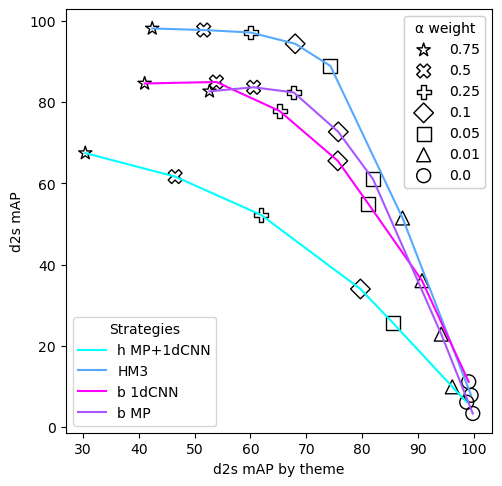

In [8]:
split = 'test' #'val'
summary_key_filter_f = lambda k: re.match(rf'{split}/t2s_mA.*',k)

runs_filter = {'config.loss_within_category_margin':0.15, 'config.approach_name':{"$regex": ".*_video"}}
data_df = get_summary_means(wandb_entity, wandb_project, runs_filter, summary_key_filter_f)


# columns sorting
data_df = data_df[[
        f"{split}/t2s_mAP",
        f"{split}/t2s_mAP_by_class"]]

data_df.columns = [c.replace('median_rank', 'medR') for c in data_df.columns]
data_df.columns = pd.MultiIndex.from_tuples([(c[len(split)+1:len(split)+4],c[len(split)+5:]) for c in data_df.columns])

second_loss_component_weights = [get_run_config(name)['second_loss_component_weight'] for name in data_df.index]
data_df['second_loss_component_weight'] = second_loss_component_weights

data_df['strategy'] = [el[7:] for el in data_df.index]

c_i_map = {k:i for i,k in enumerate(set(data_df['strategy'].values))}
w_i_map = {k:i for i,k in enumerate(sorted(data_df['second_loss_component_weight'].unique()))}
i_w_map = {k:v for v,k in w_i_map.items()}

markers = ['o', '^', 's', 'D', 'P', 'X', '*']

strategy_label_map = {
    'hier_by_room_rnn_meanPoolProc_cnn1d_video':'h MP+1dCNN',
    'hier_by_room_rnn_meanPoolProc_video':'HM3',
    'rnn_cnn1d_video':'b 1dCNN',
    'rnn_meanPoolProc_video':'b MP'
}

line_style = ['-', '--', '-.', ':']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(5.5,5.5))

# Create lists to store handles and labels for both legends
line_handles = []
line_labels = []
marker_handles_and_labels = []

# Loop over second_loss_component_weight to plot scatter points with different markers
for w in data_df['second_loss_component_weight'].unique():
    data = data_df[data_df['second_loss_component_weight'] == w]
    
    # Scatter points with color mapping and marker style
    scatter = ax.scatter(
        data[('t2s', 'mAP_by_class')], 
        data[('t2s', 'mAP')], 
        #c=[c_i_map[el[7:]] for el in data.index],  # Color mapping
        marker=markers[w_i_map[w]],
        facecolors='none',
        edgecolors='Black',
        s=100,
    )
    marker_handles_and_labels.append((scatter, w))

# Loop over strategy to plot colored lines
for i, s in enumerate(data_df['strategy'].unique()):  
    data = data_df[data_df['strategy'] == s].sort_values(by=['second_loss_component_weight'])
    
    # Extract x and y values
    x = data[('t2s', 'mAP_by_class')].values
    y = data[('t2s', 'mAP')].values
    
    # Assign a single consistent color for this strategy
    color = c_i_map[s]/max(c_i_map.values())  # Assuming c_i_map maps strategy names to colors

    # Plot line using that single color
    #line, = ax.plot(x, y, line_style[i%len(line_style)], color=plt.cm.cool(color), label=f"Strategy {s}")
    line, = ax.plot(x, y, color=plt.cm.cool(color))

    line_handles.append(line)  # Store the line for the strategy legend
    line_labels.append(strategy_label_map[s])  # Store the label for strategy legend

# Add the first legend for the lines (strategies)
line_legend = ax.legend(handles=line_handles, labels=line_labels, title="Strategies", loc="lower left")

# Add a second legend for the scatter markers (weights)
marker_handles_and_labels = sorted(marker_handles_and_labels, key=lambda x:x[1], reverse=True)
marker_legend = ax.legend(handles=[el[0] for el in marker_handles_and_labels], labels=[el[1] for el in marker_handles_and_labels], title="α weight", loc="upper right")

# Add both legends to the plot
ax.add_artist(line_legend)
ax.add_artist(marker_legend)

# Adjust plot settings
ax.set_xlabel("d2s mAP by theme")
ax.set_ylabel("d2s mAP")
#ax.set_title("mAP vs maP by class")

plt.show()

fig.savefig("../figures/mAPvsmAPbyClass.pdf", bbox_inches='tight')

In [50]:
data_df

t2s               \
                                                        mAP mAP_by_class   
1tjhZO_hier_by_room_rnn_meanPoolProc_cnn1d_video   6.076344    98.733207   
1tjh0V_hier_by_room_rnn_meanPoolProc_video         7.789867    99.516549   
1tjgen_rnn_cnn1d_video                            11.108428    99.089740   
1tjgJy_rnn_meanPoolProc_video                      3.303955    99.819205   
1tjRcy_hier_by_room_rnn_meanPoolProc_cnn1d_video  25.626198    85.500151   
1tjR36_hier_by_room_rnn_meanPoolProc_video        88.912835    74.323752   
1tjQem_rnn_cnn1d_video                            54.956571    81.111187   
1tjQFb_rnn_meanPoolProc_video                     61.038297    81.947472   
1tjPfd_hier_by_room_rnn_meanPoolProc_cnn1d_video  33.974455    79.694913   
1tjPec_hier_by_room_rnn_meanPoolProc_cnn1d_video   9.872166    96.149939   
1tjP3a_hier_by_room_rnn_meanPoolProc_video        94.386836    68.011451   
1tjP1P_hier_by_room_rnn_meanPoolProc_video        51.456475    87.242325   
1tjOvy_hier_by_room_rnn_meanPoolProc_cnn1d_video  67.454451    30.412159   
1tjOdn_rnn_cnn1d_video                            65.537085    75.645292   
1tjObZ_rnn_cnn1d_video                            36.024359    90.728297   
1tjODX_hier_by_room_rnn_meanPoolProc_video        98.153381    42.404801   
1tjOCd_rnn_meanPoolProc_video                     72.680054    75.731800   
1tjOB6_rnn_meanPoolProc_video                     22.845566    94.172384   
1tjNmV_rnn_cnn1d_video                            84.606091    41.041152   
1tjNVW_hier_by_room_rnn_meanPoolProc_cnn1d_video  52.210391    61.903683   
1tjNUi_hier_by_room_rnn_meanPoolProc_cnn1d_video  61.659010    46.506440   
1tjNLe_rnn_meanPoolProc_video                     82.673667    52.664260   
1tjMsd_hier_by_room_rnn_meanPoolProc_video        97.158045    60.024059   
1tjMrU_hier_by_room_rnn_meanPoolProc_video        97.776246    51.620154   
1tjMSb_rnn_cnn1d_video                            77.807655    65.230946   
1tjMRq_rnn_cnn1d_video                            84.968064    53.901168   
1tjM4M_rnn_meanPoolProc_video                     82.387726    67.754928   
1tjM44_rnn_meanPoolProc_video                     83.662266    60.560069   

                                                 second_loss_component_weight  \
                                                                                
1tjhZO_hier_by_room_rnn_meanPoolProc_cnn1d_video                         0.00   
1tjh0V_hier_by_room_rnn_meanPoolProc_video                               0.00   
1tjgen_rnn_cnn1d_video                                                   0.00   
1tjgJy_rnn_meanPoolProc_video                                            0.00   
1tjRcy_hier_by_room_rnn_meanPoolProc_cnn1d_video                         0.05   
1tjR36_hier_by_room_rnn_meanPoolProc_video                               0.05   
1tjQem_rnn_cnn1d_video                                                   0.05   
1tjQFb_rnn_meanPoolProc_video                                            0.05   
1tjPfd_hier_by_room_rnn_meanPoolProc_cnn1d_video                         0.10   
1tjPec_hier_by_room_rnn_meanPoolProc_cnn1d_video                         0.01   
1tjP3a_hier_by_room_rnn_meanPoolProc_video                               0.10   
1tjP1P_hier_by_room_rnn_meanPoolProc_video                               0.01   
1tjOvy_hier_by_room_rnn_meanPoolProc_cnn1d_video                         0.75   
1tjOdn_rnn_cnn1d_video                                                   0.10   
1tjObZ_rnn_cnn1d_video                                                   0.01   
1tjODX_hier_by_room_rnn_meanPoolProc_video                               0.75   
1tjOCd_rnn_meanPoolProc_video                                            0.10   
1tjOB6_rnn_meanPoolProc_video                                            0.01   
1tjNmV_rnn_cnn1d_video                                                   0.75   
1tjNVW_hier_by_room_rnn_meanPoolProc_cnn1d_video                         0

In [47]:
split = 'test' #'val'
summary_key_filter_f = lambda k: re.match(rf'{split}/t2s_((mA)|(av)).*',k)

runs_filter = {'config.loss_within_category_margin':0.15, 'config.approach_name':{"$regex": ".*_video"}}
data_df = get_summary_means(wandb_entity, wandb_project, runs_filter, summary_key_filter_f)


# # columns sorting
# data_df = data_df[[
#         f"{split}/t2s_mAP",
#         f"{split}/t2s_mAP_by_class",
#         f"{split}/t2s_avg_ndcg",
#         f"{split}/t2s_avg_ndcg_by_class"]]

In [ ]:
# test/t2s_avg_ndcg	test/t2s_avg_ndcg_by_class	test/t2s_mAP	test/t2s_mAP_by_class
# h mp+1dcnn	20.863395	99.713252	6.076344	98.733207
# hm3	22.147597	99.889445	7.789867	99.516549
# b 1dcnn	25.654039	99.820091	11.108428	99.089740
# b mp	17.030527	99.955167	3.303955	99.819205

In [48]:
data_df

,test/t2s_avg_ndcg,test/t2s_avg_ndcg_by_class,test/t2s_mAP,test/t2s_mAP_by_class
1tjhZO_hier_by_room_rnn_meanPoolProc_cnn1d_video,20.863395,99.713252,6.076344,98.733207
1tjh0V_hier_by_room_rnn_meanPoolProc_video,22.147597,99.889445,7.789867,99.516549
1tjgen_rnn_cnn1d_video,25.654039,99.820091,11.108428,99.089740
1tjgJy_rnn_meanPoolProc_video,17.030527,99.955167,3.303955,99.819205
1tjRcy_hier_by_room_rnn_meanPoolProc_cnn1d_video,40.623585,97.184537,25.626198,85.500151
1tjR36_hier_by_room_rnn_meanPoolProc_video,91.629946,94.866208,88.912835,74.323752
1tjQem_rnn_cnn1d_video,65.232154,96.426109,54.956571,81.111187
1tjQFb_rnn_meanPoolProc_video,69.738899,96.577378,61.038297,81.947472
1tjPfd_hier_by_room_rnn_meanPoolProc_cnn1d_video,47.862564,96.030651,33.974455,79.694913
1tjPec_hier_by_room_rnn_meanPoolProc_cnn1d_video,25.423647,99.307340,9.872166,96.149939


## adding video

In [84]:
split= 'test' # 'val'
summary_key_filter_f = lambda k: re.match(rf'{split}/t2s_((avg)|(mA)).*',k)

runs_filter = {'config.loss_within_category_margin':0.15, 'config.second_loss_component_weight':0.05, 'config.approach_name':{'$regex':'.*_video'}}
w_video_data_df = get_summary_means(wandb_entity, wandb_project, runs_filter, summary_key_filter_f)
w_video_data_df.index = ['_'.join(el.split('_')[1:])[:-6] for el in w_video_data_df.index]


runs_filter = {'config.loss_within_category_margin':0.15, 'config.second_loss_component_weight':0.05}
wo_video_data_df = get_summary_means(wandb_entity, wandb_project, runs_filter, summary_key_filter_f)
wo_video_data_df = wo_video_data_df.loc[[el for el in wo_video_data_df.index if not el.endswith('video')]]
wo_video_data_df.index = ['_'.join(el.split('_')[1:]) for el in wo_video_data_df.index]


diff_df = w_video_data_df - wo_video_data_df

strategy_label_map = {
    'hier_by_room_rnn_meanPoolProc_cnn1d':'h MP+1dCNN',
    'hier_by_room_rnn_meanPoolProc':'h MP+bi-GRU',
    'rnn_cnn1d':'b 1dCNN',
    'rnn_meanPoolProc':'b MP'
}

rows = []
idx = []
for name, row in wo_video_data_df.iterrows():
    rows.append(row.map(lambda x: f"{x:.1f}"))
    #rows.append(diff_df.loc[name].map(lambda x: f"{'+' if x>=0 else ''}{x:.1f}"))
    rows.append(w_video_data_df.loc[name].map(lambda x: f"{x:.1f}"))
    new_name = strategy_label_map[name]
    idx.append((new_name,'pov'))
    idx.append((new_name,'+video'))

data = pd.DataFrame(rows, index=pd.MultiIndex.from_tuples(idx))

data.columns = [el[len(split)+1:] for el in data.columns]

col_order = ['t2s_mAP','t2s_avg_ndcg','t2s_mAP_by_class','t2s_avg_ndcg_by_class']
data = data[col_order]

data

t2s_mAP t2s_avg_ndcg t2s_mAP_by_class t2s_avg_ndcg_by_class
h MP+1dCNN  pov       12.5         28.5             83.6                  96.0
            +video    25.6         40.6             85.5                  97.2
h MP+bi-GRU pov       77.7         83.0             68.8                  93.0
            +video    88.9         91.6             74.3                  94.9
b 1dCNN     pov       36.7         50.3             78.6                  95.2
            +video    55.0         65.2             81.1                  96.4
b MP        pov       29.0         43.4             77.2                  95.3
            +video    61.0         69.7             81.9                  96.6

In [85]:
print(data.to_latex())

\begin{tabular}{llllll}
\toprule
 &  & t2s_mAP & t2s_avg_ndcg & t2s_mAP_by_class & t2s_avg_ndcg_by_class \\
\midrule
\multirow[t]{2}{*}{h MP+1dCNN} & pov & 12.5 & 28.5 & 83.6 & 96.0 \\
 & +video & 25.6 & 40.6 & 85.5 & 97.2 \\
\cline{1-6}
\multirow[t]{2}{*}{h MP+bi-GRU} & pov & 77.7 & 83.0 & 68.8 & 93.0 \\
 & +video & 88.9 & 91.6 & 74.3 & 94.9 \\
\cline{1-6}
\multirow[t]{2}{*}{b 1dCNN} & pov & 36.7 & 50.3 & 78.6 & 95.2 \\
 & +video & 55.0 & 65.2 & 81.1 & 96.4 \\
\cline{1-6}
\multirow[t]{2}{*}{b MP} & pov & 29.0 & 43.4 & 77.2 & 95.3 \\
 & +video & 61.0 & 69.7 & 81.9 & 96.6 \\
\cline{1-6}
\bottomrule
\end{tabular}



## different margins 2

In [35]:
split= 'test'
summary_key_filter_f = lambda k: re.match(rf'{split}/t2s_((avg)|(mA)).*',k)

runs_filter = {'config.loss_within_category_margin':0.15, 'config.second_loss_component_weight':0.05, 'config.approach_name':{'$regex':'.*_video'}}
data_df_m15 = get_summary_means(wandb_entity, wandb_project, runs_filter, summary_key_filter_f)
data_df_m15.index = ['_'.join(el.split('_')[1:]) for el in data_df_m15.index]
data_df_m15['avg'] = data_df_m15.sum(axis=1)/4

runs_filter = {'config.loss_within_category_margin':0.10, 'config.second_loss_component_weight':0.05, 'config.approach_name':{'$regex':'.*_video'}}
data_df_m10 = get_summary_means(wandb_entity, wandb_project, runs_filter, summary_key_filter_f)
data_df_m10.index = ['_'.join(el.split('_')[1:]) for el in data_df_m10.index]
data_df_m10['avg'] = data_df_m10.sum(axis=1)/4

runs_filter = {'config.loss_within_category_margin':0.20, 'config.second_loss_component_weight':0.05, 'config.approach_name':{'$regex':'.*_video'}}
data_df_m20 = get_summary_means(wandb_entity, wandb_project, runs_filter, summary_key_filter_f)
data_df_m20.index = ['_'.join(el.split('_')[1:]) for el in data_df_m20.index]
data_df_m20['avg'] = data_df_m20.sum(axis=1)/4

diff_w_10 = data_df_m15-data_df_m10
diff_w_20 = data_df_m15-data_df_m20

strategy_label_map = {
    'hier_by_room_rnn_meanPoolProc_cnn1d_video':'h MP+1dCNN',
    'hier_by_room_rnn_meanPoolProc_video':'h MP+bi-GRU',
    'rnn_cnn1d_video':'b 1dCNN',
    'rnn_meanPoolProc_video':'b MP'
}

rows = []
idx = []
for name, row in data_df_m15.iterrows():
    rows.append(data_df_m10.loc[name].map(lambda x: f"{x:.1f}"))
    rows.append(row.map(lambda x: f"{x:.1f}"))
    # rows.append(diff_w_10.loc[name].map(lambda x: f"{'+' if x>=0 else ''}{x:.1f}"))
    # rows.append(diff_w_20.loc[name].map(lambda x: f"{'+' if x>=0 else ''}{x:.1f}"))
    rows.append(data_df_m20.loc[name].map(lambda x: f"{x:.1f}"))
    new_name = strategy_label_map[name]
    idx.append((new_name,'0.10'))
    idx.append((new_name,'0.15'))
    idx.append((new_name,'0.20'))


data = pd.DataFrame(rows, index=pd.MultiIndex.from_tuples(idx))

data.columns = [el[len(split)+1:] for el in data.columns]

col_order = ['t2s_mAP','t2s_avg_ndcg','t2s_mAP_by_class','t2s_avg_ndcg_by_class', '']
data = data[col_order]


data

t2s_mAP t2s_avg_ndcg t2s_mAP_by_class t2s_avg_ndcg_by_class  \
h MP+1dCNN  0.10    19.3         34.8             91.8                  98.5   
            0.15    25.6         40.6             85.5                  97.2   
            0.20    27.6         42.5             79.8                  96.0   
h MP+bi-GRU 0.10    78.4         83.5             83.5                  96.9   
            0.15    88.9         91.6             74.3                  94.9   
            0.20    94.4         95.8             65.4                  92.7   
b 1dCNN     0.10    49.4         60.7             87.2                  97.6   
            0.15    55.0         65.2             81.1                  96.4   
            0.20    59.3         68.7             75.3                  95.1   
b MP        0.10    50.0         60.8             89.1                  98.0   
            0.15    61.0         69.7             81.9                  96.6   
            0.20    66.8         74.3             74.9                  95.0   

                        
h MP+1dCNN  0.10  61.1  
            0.15  62.2  
            0.20  61.5  
h MP+bi-GRU 0.10  85.6  
            0.15  87.4  
            0.20  87.1  
b 1dCNN     0.10  73.7  
            0.15  74.4  
            0.20  74.6  
b MP        0.10  74.5  
            0.15  77.3  
            0.20  77.7

In [37]:
print(data.to_latex())

\begin{tabular}{lllllll}
\toprule
 &  & t2s_mAP & t2s_avg_ndcg & t2s_mAP_by_class & t2s_avg_ndcg_by_class &  \\
\midrule
\multirow[t]{3}{*}{h MP+1dCNN} & 0.10 & 19.3 & 34.8 & 91.8 & 98.5 & 61.1 \\
 & 0.15 & 25.6 & 40.6 & 85.5 & 97.2 & 62.2 \\
 & 0.20 & 27.6 & 42.5 & 79.8 & 96.0 & 61.5 \\
\cline{1-7}
\multirow[t]{3}{*}{h MP+bi-GRU} & 0.10 & 78.4 & 83.5 & 83.5 & 96.9 & 85.6 \\
 & 0.15 & 88.9 & 91.6 & 74.3 & 94.9 & 87.4 \\
 & 0.20 & 94.4 & 95.8 & 65.4 & 92.7 & 87.1 \\
\cline{1-7}
\multirow[t]{3}{*}{b 1dCNN} & 0.10 & 49.4 & 60.7 & 87.2 & 97.6 & 73.7 \\
 & 0.15 & 55.0 & 65.2 & 81.1 & 96.4 & 74.4 \\
 & 0.20 & 59.3 & 68.7 & 75.3 & 95.1 & 74.6 \\
\cline{1-7}
\multirow[t]{3}{*}{b MP} & 0.10 & 50.0 & 60.8 & 89.1 & 98.0 & 74.5 \\
 & 0.15 & 61.0 & 69.7 & 81.9 & 96.6 & 77.3 \\
 & 0.20 & 66.8 & 74.3 & 74.9 & 95.0 & 77.7 \\
\cline{1-7}
\bottomrule
\end{tabular}



## compare the standard triplet with the 2 component one

In [88]:
split= 'test'
summary_key_filter_f = lambda k: re.match(rf'{split}/t2s_((avg)|(mA)).*',k)

runs_filter = {'config.loss_within_category_margin':0.15, 'config.second_loss_component_weight':0.05, 'config.approach_name':{'$regex':'.*_video'}}
two_loss_data_df = get_summary_means(wandb_entity, wandb_project, runs_filter, summary_key_filter_f)
two_loss_data_df.index = ['_'.join(el.split('_')[1:]) for el in two_loss_data_df.index]
two_loss_data_df

runs_filter = {'tags':{'$eq':'new 16th'}}
stl_data_df = get_summary_means(wandb_entity, wandb_project, runs_filter, summary_key_filter_f)
stl_data_df.index = ['_'.join(el.split('_')[1:]) for el in stl_data_df.index]
stl_data_df

,test/t2s_avg_ndcg,test/t2s_avg_ndcg_by_class,test/t2s_mAP,test/t2s_mAP_by_class
hier_by_room_rnn_meanPoolProc_cnn1d_video,56.758012,88.008165,44.642903,52.672254
hier_by_room_rnn_meanPoolProc_video,99.482095,84.594423,99.304787,41.239909
rnn_cnn1d_video,85.484652,87.908514,80.889306,50.258633
rnn_meanPoolProc_video,88.892565,89.220184,85.476085,53.799627


In [89]:
diff_df = stl_data_df -  two_loss_data_df

strategy_label_map = {
    'hier_by_room_rnn_meanPoolProc_cnn1d_video':'h MP+1dCNN',
    'hier_by_room_rnn_meanPoolProc_video':'h MP+bi-GRU',
    'rnn_cnn1d_video':'b 1dCNN',
    'rnn_meanPoolProc_video':'b MP'
}

rows = []
idx = []
for name, row in two_loss_data_df.iterrows():
    rows.append(row.map(lambda x: f"{x:.1f}"))
    rows.append(stl_data_df.loc[name].map(lambda x: f"{x:.1f}"))
    #rows.append(diff_df.loc[name].map(lambda x: f"{'+' if x>=0 else ''}{x:.1f}"))
    new_name = strategy_label_map[name]
    idx.append((new_name,'DCN+STN'))
    idx.append((new_name,'stl'))

data = pd.DataFrame(rows, index=pd.MultiIndex.from_tuples(idx))

data.columns = [el[len(split)+1:] for el in data.columns]

col_order = ['t2s_mAP','t2s_avg_ndcg','t2s_mAP_by_class','t2s_avg_ndcg_by_class']
data = data[col_order]

data

t2s_mAP t2s_avg_ndcg t2s_mAP_by_class  \
h MP+1dCNN  DCN+STN    25.6         40.6             85.5   
            stl        44.6         56.8             52.7   
h MP+bi-GRU DCN+STN    88.9         91.6             74.3   
            stl        99.3         99.5             41.2   
b 1dCNN     DCN+STN    55.0         65.2             81.1   
            stl        80.9         85.5             50.3   
b MP        DCN+STN    61.0         69.7             81.9   
            stl        85.5         88.9             53.8   

                    t2s_avg_ndcg_by_class  
h MP+1dCNN  DCN+STN                  97.2  
            stl                      88.0  
h MP+bi-GRU DCN+STN                  94.9  
            stl                      84.6  
b 1dCNN     DCN+STN                  96.4  
            stl                      87.9  
b MP        DCN+STN                  96.6  
            stl                      89.2

In [90]:
print(data.to_latex())

\begin{tabular}{llllll}
\toprule
 &  & t2s_mAP & t2s_avg_ndcg & t2s_mAP_by_class & t2s_avg_ndcg_by_class \\
\midrule
\multirow[t]{2}{*}{h MP+1dCNN} & DCN+STN & 25.6 & 40.6 & 85.5 & 97.2 \\
 & stl & 44.6 & 56.8 & 52.7 & 88.0 \\
\cline{1-6}
\multirow[t]{2}{*}{h MP+bi-GRU} & DCN+STN & 88.9 & 91.6 & 74.3 & 94.9 \\
 & stl & 99.3 & 99.5 & 41.2 & 84.6 \\
\cline{1-6}
\multirow[t]{2}{*}{b 1dCNN} & DCN+STN & 55.0 & 65.2 & 81.1 & 96.4 \\
 & stl & 80.9 & 85.5 & 50.3 & 87.9 \\
\cline{1-6}
\multirow[t]{2}{*}{b MP} & DCN+STN & 61.0 & 69.7 & 81.9 & 96.6 \\
 & stl & 85.5 & 88.9 & 53.8 & 89.2 \\
\cline{1-6}
\bottomrule
\end{tabular}



## quality assessment of the ranking 

In [9]:
def get_runs(wandb_entity, wandb_project, wandb_runs_filter, wandb_api=WANDB_API):
    """get mean and std values for some metrics filtered with summary_key_filter_f from runs filtered by run_filter and grouped by the the run name

    Args:
        summary_key_filter_f : function to filter the summary key strings

    """
    runs = wandb_api.runs(f"{wandb_entity}/{wandb_project}", filters=wandb_runs_filter) 

    tries_by_run = defaultdict(lambda:[])
    for run in runs:
        tries_by_run[run.config['run']].append(run)

    return tries_by_run

In [22]:
def get_index_of_best_try(data, metric_name):
    metrics = {i:el['metrics'][metric_name] for i,el in enumerate(data)}
    return max(metrics, key=metrics.get)



def get_map_quantile_indices(runs_data, quantiles=[0.25, 0.5, 0.75], by_class=True):
    # if i is None the worse index is considered and returned 
    output_dir = create_local_res_dir_from_runs(runs_data, 'generatedDigitalExps', os.path.join('..', 'outputs', 'models'))

    with open(os.path.join(output_dir, 'test_output.json')) as f:
        data = json.load(f)

    try_idx = get_index_of_best_try(data, 't2s_mAP_by_class')#'t2s_mAP')
    print(f'{output_dir} - {try_idx}')
    run_data = data[try_idx] # this may be based on the best run

    descriptions_fv = torch.tensor(run_data['output_description_test'])
    exhib_fv = torch.tensor(run_data['output_pov_test'])
    categories = torch.tensor(run_data['output_categories'])
    ids = run_data['ids_list']
    
    sim_matrix = cosine_sim(descriptions_fv, exhib_fv)

    if not by_class:
        true_similarity = torch.eye(sim_matrix.shape[0])
    else:
        true_similarity = (categories == categories.unsqueeze(1)).int()
    
    values = pd.DataFrame(average_precision_score(true_similarity.T, sim_matrix.T, average=None))

    quantile_values = values.quantile(quantiles).iloc[:,0]

    indices = []
    for q in quantile_values:
        # Calculate absolute differences and find index of minimum
        closest_index = (values - q).abs().idxmin().item()
        indices.append(closest_index)
    return indices, quantile_values,values,ids


def display_ranking_quality(runs_data, name, i = None, limit_pos=None, name_map=None, ax=None, show_title=True, rel_thickness=10):
    # if i is None the worse index is considered and returned 
    output_dir = create_local_res_dir_from_runs(runs_data, 'generatedDigitalExps', os.path.join('..', 'outputs', 'models'))

    with open(os.path.join(output_dir, 'test_output.json')) as f:
        data = json.load(f)

    try_idx = get_index_of_best_try(data, 't2s_mAP_by_class')#'t2s_mAP')
    run_data = data[try_idx] # this may be based on the best run

    descriptions_fv = torch.tensor(run_data['output_description_test'])
    exhib_fv = torch.tensor(run_data['output_pov_test'])
    categories = torch.tensor(run_data['output_categories'])
    ids = run_data['ids_list']

    sim_matrix = cosine_sim(descriptions_fv, exhib_fv)


    if i is None: # if i si none the worse element is picked
        i = (sim_matrix.argsort(dim=1,descending=True) == torch.tensor(range(sim_matrix[1].shape[0])).unsqueeze(1)).nonzero(as_tuple=True)[1].argmax()


    limit_pos = len(sim_matrix[0]) if limit_pos is None else limit_pos

    # Example array of integer values
    ranking = sim_matrix[i].argsort(descending=True)[:limit_pos]
    array = categories[ranking]

    highlight_index = (ranking == i).nonzero(as_tuple=True)[0].item() # position of the true match
    array = (array == categories[i]).int()

    # Reshape the array to be 2D with a single row
    data = np.array(array).reshape(1, -1)


    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 1))
        
    # Plot the data on the given axis
    ax.imshow(data, aspect='auto', cmap='copper')#cmap='inferno')
    
    # Add title
    if show_title:
        #title = name_map['_'.join(name.split('_')[1:])] if name_map is not None else name
        #title, fontsize=10)
        ax.set_title(ids[i])
    
    # Add the highlight
    rect = patches.Rectangle(
        (highlight_index - 0.5, -0.5),   # (x, y) starting point
        max(1, int(limit_pos * rel_thickness / 2000)),  # Width of the highlight
        1,                              # Height of the highlight
        linewidth=0,
        edgecolor='none',
        facecolor='cyan',
        zorder=2  # Put on top
    )
    ax.add_patch(rect)

    # Remove axis for a cleaner look
    ax.axis('off')

    return i, run_data

In [11]:
split= 'test'

original_name_map = {
    'hier_by_room_rnn_meanPoolProc_cnn1d':'h MP+1dCNN',
    'hier_by_room_rnn_meanPoolProc':'HM3',
    'rnn_cnn1d':'b 1dCNN',
    'rnn_meanPoolProc':'b MP'
}


runs_filter_18 = {'tags':{'$eq': 'new 18th 2nd w 0.05'}, '$and':[{'config.approach_name':{'$regex':'.*_video'}}, {'$not': {'config.approach_name':{'$regex':'.*cnn1d.*'}}}]}
runs_18 = get_runs(wandb_entity, wandb_project, runs_filter_18)
name_map_18 = {f'{k}_video':f'{v}\ndouble loss' for k,v in original_name_map.items()}

runs_filter_16 = {'tags':{'$eq': 'new 16th'}, '$not': {'config.approach_name':{'$regex':'.*cnn1d.*'}}}#, 'config.approach_name':{'$regex':'hier.*'}}
runs_16 = get_runs(wandb_entity, wandb_project, runs_filter_16)
name_map_16 = {f'{k}_video':f'{v}\nSTL' for k,v in original_name_map.items()}



v_s_18 = {}
i_s_18 = []
v_s_16 = {}
i_s_16 = []
ids_s_16 = []
ids_s_18 = []


for name, runs in runs_18.items():
    actual_name = name_map_18["_".join(name.split("_")[1:])]
    idexes,quantiles, v, ids = get_map_quantile_indices(runs)
    v_s_18[actual_name] = v.values.reshape(-1)
    i_s_18.append(idexes)
    ids_s_18.append(ids)

for name, runs in runs_16.items():
    actual_name = name_map_16["_".join(name.split("_")[1:])]
    idexes,quantiles,v,ids = get_map_quantile_indices(runs)
    v_s_16[actual_name] = v.values.reshape(-1)
    i_s_16.append(idexes)
    ids_s_16.append(ids)


../outputs/models/generatedDigitalExps_1tjR36_hier_by_room_rnn_meanPoolProc_video_2 - 1
../outputs/models/generatedDigitalExps_1tjQFb_rnn_meanPoolProc_video_2 - 2
../outputs/models/generatedDigitalExps_1tjzS9_hier_by_room_rnn_meanPoolProc_video_2 - 0
../outputs/models/generatedDigitalExps_1tjwOQ_rnn_meanPoolProc_video_2 - 1


printing images for index 1094
printing images for index 909
printing images for index 1640
printing images for index 1355
printing images for index 1327
printing images for index 283
printing images for index 792
printing images for index 929
printing images for index 1525
printing images for index 737
printing images for index 1626
printing images for index 358


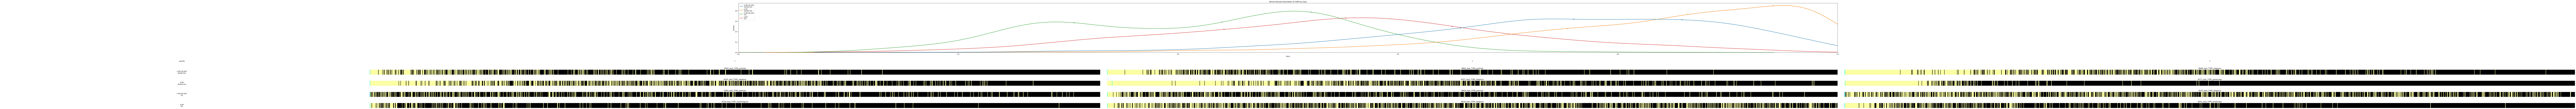

In [ ]:
limit_pos = None

# Create a figure
fig = plt.figure(figsize=(11*1.15, 9*1.15))# was 8,11

gaus_v_cells= 5
gs = gridspec.GridSpec(len(v_s_18)+len(v_s_16)+1+gaus_v_cells, 7, figure=fig)

v_off = gaus_v_cells
ax = fig.add_subplot(gs[v_off,0])
ax.axis('off')
ax.text(0.5,0.5,f'quartile', ha='center', va='center', )
for i in range(3):
    ax = fig.add_subplot(gs[v_off,2*i+1:2*i+3])
    ax.axis('off')
    ax.text(0.5,0.5,f'{i+1}', ha='center', va='center', )
v_off+=1

for k, (name, runs) in enumerate(runs_18.items()):
    actual_name = name_map_18["_".join(name.split("_")[1:])]
    idexes = i_s_18[k]

    ax = fig.add_subplot(gs[v_off,0])
    ax.axis('off')
    ax.text(0.5,0.5,f'{actual_name}', ha='center', va='center', )

    for j, i in enumerate(idexes):
        print(f'printing images for index {i}')
        ax = fig.add_subplot(gs[v_off,2*j+1:2*j+3])
        _ = display_ranking_quality(runs, name, i, limit_pos, name_map=name_map_18, ax=ax)
        
    v_off+=1


for k, (name, runs) in enumerate(runs_16.items()):
    actual_name = name_map_16["_".join(name.split("_")[1:])]
    idexes = i_s_16[k]

    ax = fig.add_subplot(gs[v_off,0])
    ax.axis('off')
    ax.text(0.5,0.5,f'{actual_name}', ha='center', va='center', )

    for j, i in enumerate(idexes):
        print(f'printing images for index {i}')
        ax = fig.add_subplot(gs[v_off,2*j+1:2*j+3])
        _ = display_ranking_quality(runs, name, i, limit_pos, name_map=name_map_16, ax=ax)
    
    v_off+=1


ax = fig.add_subplot(gs[0:gaus_v_cells, 2:-2])

ax.axis(xmin=0, xmax=1)

all_data = {**v_s_18, **v_s_16}

kde = sns.kdeplot(all_data, linewidth=2, color=color, ax=ax).get_lines()

for i,line in enumerate(reversed(kde)):
    qs = [0.25,0.5,0.75]
    quantile_vals = [np.quantile(list(all_data.values())[i],q) for q in qs]
    plt.scatter(quantile_vals, [line.get_ydata()[abs(line.get_xdata()  - qv).argmin()] for qv in quantile_vals ], marker='x')

# # Add labels and title
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.set_title('Kernel Density Estimation of mAP by class')


# Adjust layout
plt.tight_layout()
plt.show()



In [361]:
fig.savefig("../figures/qualityRankings_ext_long.pdf", bbox_inches='tight')

### wider plot

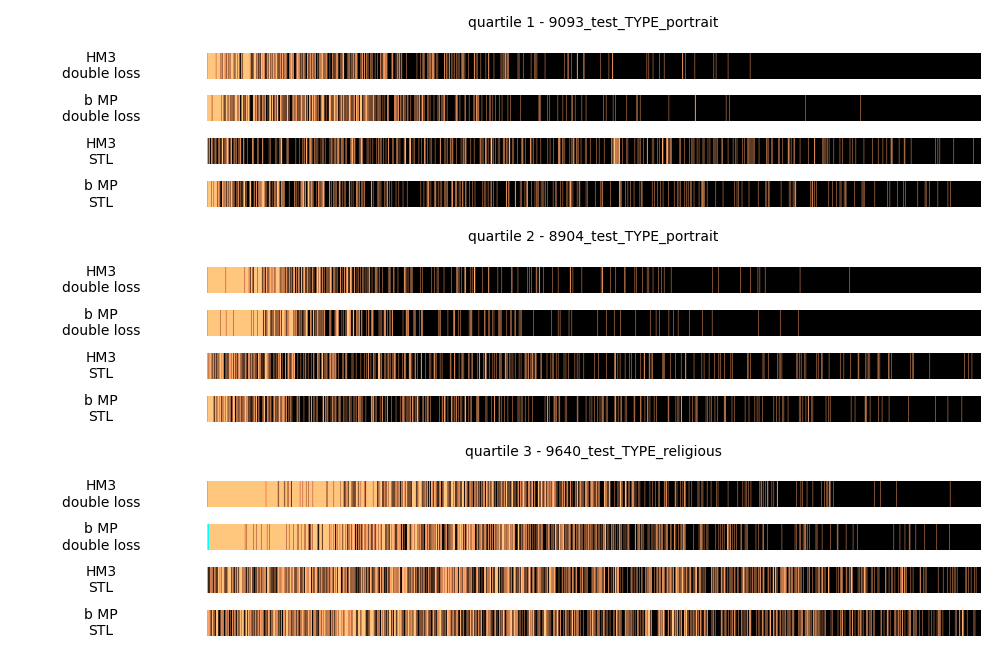

In [23]:
limit_pos = None
rel_thickness = 2

# Create a figure
fig = plt.figure(figsize=(10, 7))# was 8,11

gaus_v_cells= 0
gs = gridspec.GridSpec((len(v_s_18)+len(v_s_16)+1)*len(i_s_18[0])+1+gaus_v_cells, 5, figure=fig)

v_off = gaus_v_cells+1

for k, idx in enumerate(i_s_18[0]):
    ax = fig.add_subplot(gs[v_off,1:])
    ax.axis('off')
    ax.text(0.5,0.5,f'quartile {k+1} - {ids_s_18[0][idx]}', ha='center', va='center', )
    v_off+=1
    
    for k, (name, runs) in enumerate(runs_18.items()):
        actual_name = name_map_18["_".join(name.split("_")[1:])]

        ax = fig.add_subplot(gs[v_off,0])
        ax.axis('off')
        ax.text(0.5,0.5,f'{actual_name}', ha='center', va='center', )

        
        ax = fig.add_subplot(gs[v_off,1:])
        _ = display_ranking_quality(runs, name, idx, limit_pos, name_map=name_map_18, ax=ax, show_title=False, rel_thickness=rel_thickness)
            
        v_off+=1


    for k, (name, runs) in enumerate(runs_16.items()):
        actual_name = name_map_16["_".join(name.split("_")[1:])]

        ax = fig.add_subplot(gs[v_off,0])
        ax.axis('off')
        ax.text(0.5,0.5,f'{actual_name}', ha='center', va='center', )

        
        ax = fig.add_subplot(gs[v_off,1:])
        _ = display_ranking_quality(runs, name, idx, limit_pos, name_map=name_map_16, ax=ax, show_title=False, rel_thickness=rel_thickness)
            
        v_off+=1


# ax = fig.add_subplot(gs[0:gaus_v_cells, 1:-1])

# ax.axis(xmin=0, xmax=1)

# all_data = {k:v for k,v in v_s_18.items() if k.startswith('h')}

# kde = sns.kdeplot(all_data, linewidth=2, ax=ax).get_lines()

# for i,line in enumerate(reversed(kde)):
#     qs = [0.25,0.5,0.75]
#     quantile_vals = [np.quantile(list(all_data.values())[i],q) for q in qs]
#     plt.scatter(quantile_vals, [line.get_ydata()[abs(line.get_xdata()  - qv).argmin()] for qv in quantile_vals ], marker='x')


# # # Add labels and title
# ax.set_xlabel('Value')
# ax.set_ylabel('Density')
# ax.set_title('Kernel Density Estimation of mAP by class')


# Adjust layout
plt.tight_layout()
plt.show()



In [25]:
fig.savefig("../figures/qualityRankings_quartilesFromSingleModel.pdf", bbox_inches='tight')

## quality assessment of ranking

In [ ]:
def get_index_of_best_try(data, metric_name):
    metrics = {i:el['metrics'][metric_name] for i,el in enumerate(data)}
    return max(metrics, key=metrics.get)

def get_map_scores(runs_data, quantiles=[0.25, 0.5, 0.75], by_class=True):
    # if i is None the worse index is considered and returned 
    output_dir = create_local_res_dir_from_runs(runs_data, 'generatedDigitalExps', os.path.join('..', 'outputs', 'models'))

    with open(os.path.join(output_dir, 'test_output.json')) as f:
        data = json.load(f)

    try_idx = get_index_of_best_try(data, 't2s_mAP_by_class')#'t2s_mAP')
    run_data = data[try_idx] # this may be based on the best run

    descriptions_fv = torch.tensor(run_data['output_description_test'])
    exhib_fv = torch.tensor(run_data['output_pov_test'])
    categories = torch.tensor(run_data['output_categories'])
    ids = run_data['ids_list']
    
    sim_matrix = cosine_sim(descriptions_fv, exhib_fv)

    if not by_class:
        true_similarity = torch.eye(sim_matrix.shape[0])
    else:
        true_similarity = (categories == categories.unsqueeze(1)).int()
    
    values = pd.DataFrame(average_precision_score(true_similarity.T, sim_matrix.T, average=None))

    return values, ids, sim_matrix

runs_filter_18_h_only = {'tags':{'$eq': 'new 18th 2nd w 0.05'}, '$and':[{'config.approach_name':{'$regex':'.*_video'}}, {'$not': {'config.approach_name':{'$regex':'.*cnn1d.*'}}}] , 'config.approach_name':{'$regex':'hier.*'}}
runs_18_h_only = get_runs(wandb_entity, wandb_project, runs_filter_18)
name_map_18_h_only = {f'{k}_video':f'{v}\ndouble loss' for k,v in original_name_map.items()}


values, indices, sim_matrix = get_map_scores(list(runs_18_h_only.values())[0])